# Problem set 2 (40 + 36 + 35 = 111 pts)

In this problem set we also present some bonus problems that will be considered as in Problem Set 1.

## Problem 1. Segmentation. (40 pts)
In this task, you will need to solve the problem of semantic segmentation of the attributes of a person's face. You will work with [CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ) dataset. You are free to solve and implement required steps on your own. However, there are several constraints and advices:
- To speed up and simplify experiments, you can transform images to 512x512 resolution and use this [train-test split](https://drive.google.com/file/d/1vO4mJ08FMdcom2-sNs4WHxPztIRYrFYI/view?usp=share_link), that has smaller number of images.
- (20 pts) Implement needed train-test pipeline (dataset, model, train and test loops), train and test the model. 
  - (10 pts) Bonus: your own model, not taken from libraries and not a Unet.
- (5 pts) Report IoU and Dice-scores of each class on the test set.
- (5 pts) Try to add augmentations (helpful [link1](https://albumentations.ai/) and [link2](https://kornia.github.io/)).
- (2 pts) Plot 4-6 examples of obtained results on the test set (show the best and the worst according to the loss/metrics).
- (3 pts) Explain why you solved the problem this way and not otherwise, provide description of experiments and their results. Analyze your metrics, are they suitable?
- (5 pts) Make additional function for inference that receives path to the image. Test your model on several photos not from the dataset (pick your own photo or any other from internet). Does your model work well on the new data?
- Do not use already pretrained on CelebAMask-HQ models.
- **Bonus**: 
  - **+10 points** for top-1 result
  - **+8 points** for 2-3 places
  - **+5 points** for 4-8 places 
according to reported mean Dice score on the provided test split.

In [1]:

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image
import os
from torch.utils.data import Dataset,DataLoader
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
class CelebAMaskHQ():
    def __init__(self, img_path, label_path, transform_img, transform_label, mode):
        self.img_path = img_path
        self.label_path = label_path
        self.transform_img = transform_img
        self.transform_label = transform_label
        self.train_dataset = []
        self.test_dataset = []
        self.mode = mode
        self.preprocess()
        
        if mode == True:
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        
        imgs = np.sort(os.listdir(self.img_path))
        masks = np.sort(os.listdir(self.label_path))
        for i in range(len([name for name in os.listdir(self.img_path) if os.path.isfile(os.path.join(self.img_path, name))])):
            img_path = os.path.join(self.img_path, imgs[i])
            label_path = os.path.join(self.label_path, masks[i]) 
            if self.mode == True:
                self.train_dataset.append([img_path, label_path])
            else:
                self.test_dataset.append([img_path, label_path])
            
        #print('Finished preprocessing the CelebA dataset...')
        
        

    def __getitem__(self, index):
        
        dataset = self.train_dataset if self.mode == True else self.test_dataset
        img_path, label_path = dataset[index]
        image = Image.open(img_path)
        label = Image.open(label_path)
        return self.transform_img(image), self.transform_label(label)


    def __len__(self):
        """Return the number of images."""
        return self.num_images

class Data_Loader():
    def __init__(self, img_path, label_path, image_size, batch_size, mode):
        self.img_path = img_path
        self.label_path = label_path
        self.imsize = image_size
        self.batch = batch_size
        self.mode = mode

    def transform_img(self, resize, totensor, normalize, centercrop):
        options = []
        if totensor:
            options.append(transforms.ToTensor())
        if centercrop:
            options.append(transforms.CenterCrop(160))
        if resize:
            options.append(transforms.Resize((self.imsize,self.imsize)))
        if normalize:
            options.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        transform = transforms.Compose(options)
        return transform

    def transform_label(self, resize, totensor, normalize, centercrop):
        options = []
        if totensor:
            options.append(transforms.ToTensor())
        if centercrop:
            options.append(transforms.CenterCrop(128))
        if resize:
            options.append(transforms.Resize((self.imsize,self.imsize)))
        if normalize:
            options.append(transforms.Normalize((0, 0, 0), (0, 0, 0)))
        transform = transforms.Compose(options)
        return transform

    def loader(self,shuffle=True):
        transform_img = self.transform_img(True, True, True, False) 
        transform_label = self.transform_label(True, True, False, False)  
        dataset = CelebAMaskHQ(self.img_path, self.label_path, transform_img, transform_label, self.mode)

        loader = torch.utils.data.DataLoader(dataset=dataset,
                                             batch_size=self.batch,
                                             shuffle=shuffle,
                                             drop_last=False)
        return loader

In [3]:
class Encoder_Block(torch.nn.Module):
  def __init__(self,inp_channels,out_channels):
    super().__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
    )
    self.pooling = torch.nn.MaxPool2d(2)
  def forward(self,x):
    int_out = self.model(x)
    return self.pooling(int_out), int_out

class Decoder_Block(torch.nn.Module):
  def __init__(self,inp_channels,out_channels):
    super().__init__()
    self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
    )
  def forward(self,x,enc_x):
    x = self.upsample(x)
    x = torch.cat([x,enc_x],dim=1)
    return self.model(x)
     

In [4]:
class Unet(torch.nn.Module):
  def __init__(self,inc,outc,hidden_size=64):
    super().__init__()
    self.Encoder = torch.nn.ModuleList([
        Encoder_Block(inc,hidden_size),
        Encoder_Block(hidden_size,hidden_size*2),
        Encoder_Block(hidden_size*2,hidden_size*4),
        Encoder_Block(hidden_size*4,hidden_size*8),
    ])
    self.bottleneck = torch.nn.Sequential(
        torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
        torch.nn.BatchNorm2d(hidden_size*16),
        torch.nn.ReLU(),
        torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
        torch.nn.BatchNorm2d(hidden_size*16),
        torch.nn.ReLU()
    )
    self.Decoder = torch.nn.ModuleList([
        Decoder_Block(hidden_size*16,hidden_size*8),
        Decoder_Block(hidden_size*8,hidden_size*4),
        Decoder_Block(hidden_size*4,hidden_size*2),
        Decoder_Block(hidden_size*2,hidden_size*1),
    ])
    self.last_layer = torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same")
  def forward(self,x):
    enc_xs = []
    for module in self.Encoder:
      x, enc_x= module(x)
      enc_xs.append(enc_x)
    
    enc_xs = enc_xs[::-1]
    x = self.bottleneck(x)

    for i,module in enumerate(self.Decoder):
      x = module(x,enc_xs[i])
    
    return self.last_layer(x)

In [ ]:
os.chdir('..')

In [ ]:

config = dict()
config['img_path'] = os.path.join(os.getcwd(),r'Desktop\skoltech_courses\dl\hw2\dataset\train\CelebA-HQ-img')
config['label_path'] = os.path.join(os.getcwd(),r'Desktop\skoltech_courses\dl\hw2\dataset\train\CelebAMask-HQ-mask')
config['imsize'] = 512
config['batch_size'] = 1
config['train'] = True

data = Data_Loader(config['img_path'], config['label_path'], config['imsize'],
                             config['batch_size'], config['train'])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = Unet(3,19).to(device)
dataloader = data.loader()
optimizer = torch.optim.Adam(unet.parameters(),lr=0.001)

In [339]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht or w != wt:
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )
    return loss

In [340]:
def train(model,dataloader,optimizer,loss_func=cross_entropy2d,epochs=5):
    model.train()
    for i in range(epochs):
        for x,labels in tqdm(dataloader):
            x = x.to(device)

            size = labels.size()
            labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
            labels_real_plain = labels[:, 0, :, :].to(device)
            
            out = model(x)

            loss = loss_func(out,labels_real_plain.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    print(i)

In [ ]:
train(unet,dataloader,optimizer)

In [5]:
def dice(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth).item()

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice_res = []
    for index in range(numLabels):
        if torch.sum(y_true[:,index,:,:]).item()==0:
            dice_res.append('absent')
        else:
            dice_res.append(dice(y_true[:,index,:,:], y_pred[:,index,:,:]))
    return dice_res

def iou(y_true,y_pred):
    intersection = torch.logical_and(y_true,y_pred)
    union = torch.logical_or(y_true,y_pred)
    iou_score = torch.sum(intersection) / torch.sum(union)
    return iou_score.item()

def iou_multilabel(y_true,y_pred,numLabels):
    iou_res = []
    for index in range(numLabels):
        if torch.sum(y_true[:,index,:,:]).item()==0:
            iou_res.append('absent')
        else:
            iou_res.append(iou(y_true[:,index,:,:], y_pred[:,index,:,:]))
    return iou_res

In [6]:
def get_binary_masks(labels):
    size = labels.size()
    labels = labels[:, 0, :, :].view(size[0], 1, size[2], size[3])
    oneHot_size = (size[0], 19, size[2], size[3])
    labels_real = torch.FloatTensor(torch.Size(oneHot_size)).zero_()
    labels_real = labels_real.scatter_(1, labels.data.long(), 1.0)   
    return labels_real

In [356]:
def test(model,dataloader,metrics,loss_func=cross_entropy2d):
    model.eval()
    
    res = dict()
    
    for i,batch in tqdm(enumerate(dataloader)):
        res_sample = dict()
        x = batch[0].to(device)
        labels = batch[1]
        labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
        labels_real_plain = labels[:, 0, :, :]

        out = model(x).cpu()
        with torch.no_grad():
            loss = loss_func(out,labels_real_plain.long())
            
        labels_real = get_binary_masks(labels) 
        
        preds = torch.argmax(out,dim=1).unsqueeze(0)
        preds_real = get_binary_masks(preds)
        dice_score = metrics['dice'](labels_real, preds_real, 19)
        iou_score = metrics['iou'](labels_real, preds_real, 19)
        
        
        res_sample['dice_class'] = dice_score
        res_sample['iou_class'] = iou_score
        
        res[i] = res_sample
    return res

In [348]:
#!g1.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = Unet(3,19).to(device)
print(device)

cuda


In [349]:
#!g1.1
unet.load_state_dict(torch.load('./model_params'))

<All keys matched successfully>

In [350]:
#!g1.1
config = dict()
config['img_path'] = '/home/jupyter/mnt/datasets/CELEBS_DATA/dataset/test/CelebA-HQ-img'
config['label_path'] = '/home/jupyter/mnt/datasets/CELEBS_DATA/dataset/test/CelebAMask-HQ-mask'
config['imsize'] = 512
config['batch_size'] = 1
config['train'] = False
data = Data_Loader(config['img_path'], config['label_path'], config['imsize'],
                             config['batch_size'], config['train'])
dataloader = data.loader(False)

metrics = dict()
metrics['dice'] = dice_coef_multilabel
metrics['iou'] = iou_multilabel

In [357]:
#!g1.1
res = test(unet,dataloader,metrics)

0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
1it [00:02,  2.53s/it]/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
2it [00:02,  1.81s/it]/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
3it [00:02,  1.32s/it]/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
4it [00:02,  1.04it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_av

In [361]:
#!g1.1
torch.save(res,'fin_results')

In [362]:
#!g1.1
def get_general(x):
    results = [i for i in x if type(i)==torch.Tensor]
    return sum(results)/len(results)

In [364]:
#!g1.1
dice_scores = []

for i in range(1250):
    dice_scores.append(get_general(res[i]['dice_class']))
    
dice_scores = np.array(dice_scores)
top_max = list(np.argpartition(dice_scores, -4)[-4:])
top_min = list(np.argpartition(dice_scores,4)[:4])

In [365]:
#!g1.1
top_images = []
top_labels = []

low_images = []
low_labels = []

for i,batch in tqdm(enumerate(dataloader)):
    if i in top_max:
        top_images.append(batch[0])
        top_labels.append(batch[1])
    elif i in top_min:
        low_images.append(batch[0])
        low_labels.append(batch[1])
    
    if (len(top_images)==4) and (len(low_images)==4):
        break

867it [00:29, 29.28it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


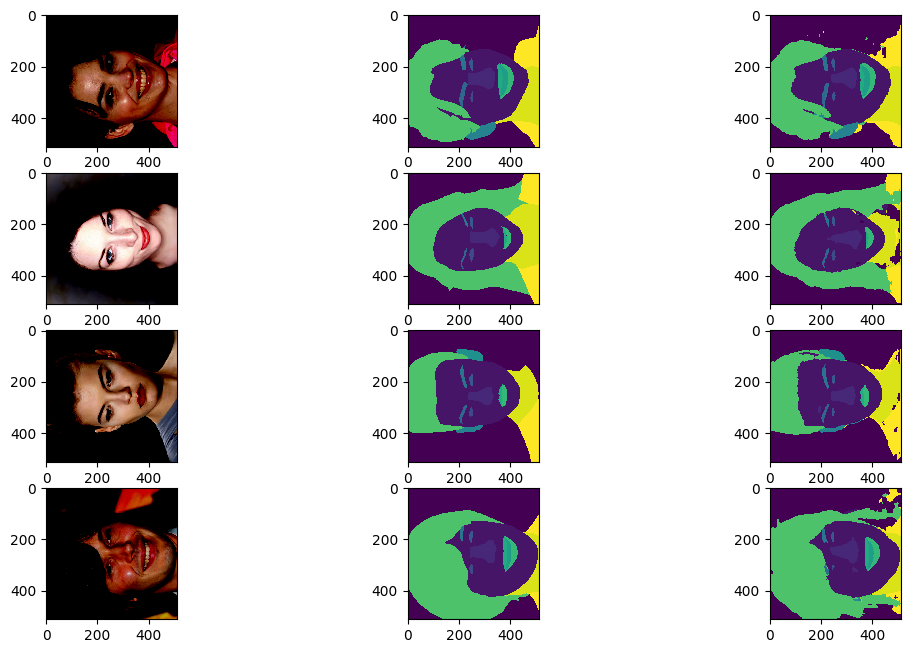

In [380]:
#!g1.1
fig, ax = plt.subplots(4,3,figsize=(14,8))
fig.set_dpi(100)
plt.subplots_adjust(wspace = 0.001)
for i in range(4):
    out = unet(top_images[i].to(device)).cpu()
    preds = torch.argmax(out,dim=1)
    ax[i,0].imshow(top_images[i][0].T)
    ax[i,1].imshow(top_labels[i][0].T[:,:,0])
    ax[i,2].imshow(preds.detach()[0].T)      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


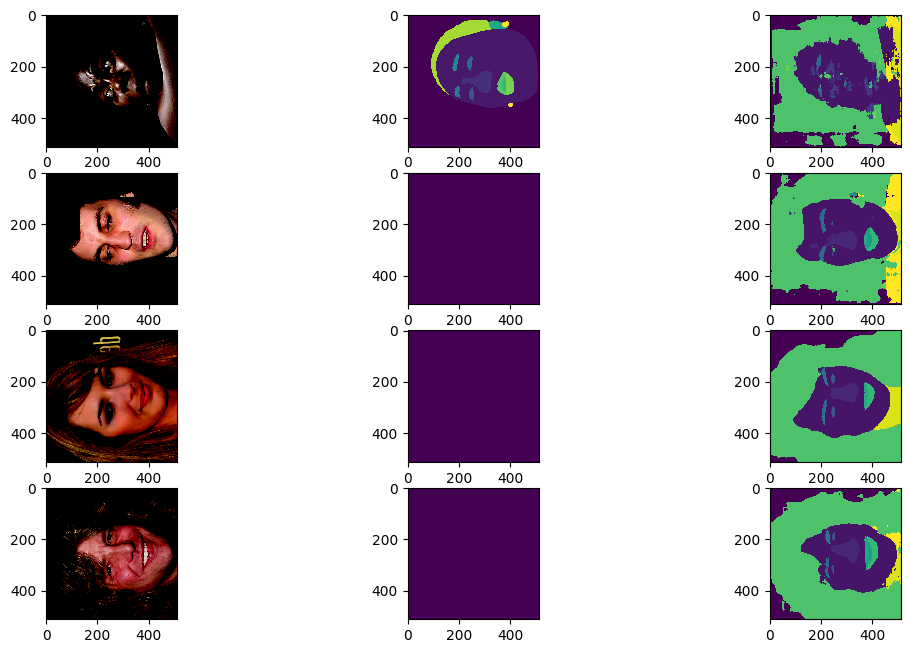

In [381]:
#!g1.1
fig, ax = plt.subplots(4,3,figsize=(14,8))
fig.set_dpi(100)
plt.subplots_adjust(wspace = 0.001)
for i in range(4):
    out = unet(low_images[i].to(device)).cpu()
    preds = torch.argmax(out,dim=1)
    ax[i,0].imshow(low_images[i][0].T)
    ax[i,1].imshow(low_labels[i][0].T[:,:,0])
    ax[i,2].imshow(preds.detach()[0].T)      

Something weird with the mask happened on preprocessing stage. Nevertheless, first 2 outputs are bad.

In [50]:
res = torch.load('./Downloads/fin_results')

In [61]:
def common_metrics(results):
    counts = np.zeros((1,19))
    scores = np.zeros((1,19))
    for i in range(1250):
        dice_scores = results[i]['dice_class']
        for j,score in enumerate(dice_scores):
            if type(score)==torch.Tensor:
                counts[0,j]+=1
                scores[0,j]+=score.item()
    return scores/counts

In [70]:
results = common_metrics(res)
for i in range(19):
    print(f'for class {i} dice score is: {np.round(results[0,i],3)}')
print(f'mean value is {np.round(np.mean(results),3)}')

for class 0 dice score is: 0.851
for class 1 dice score is: 0.916
for class 2 dice score is: 0.877
for class 3 dice score is: 0.393
for class 4 dice score is: 0.136
for class 5 dice score is: 0.497
for class 6 dice score is: 0.517
for class 7 dice score is: 0.58
for class 8 dice score is: 0.537
for class 9 dice score is: 0.509
for class 10 dice score is: 0.722
for class 11 dice score is: 0.751
for class 12 dice score is: 0.748
for class 13 dice score is: 0.855
for class 14 dice score is: 0.136
for class 15 dice score is: 0.363
for class 16 dice score is: 0.0
for class 17 dice score is: 0.776
for class 18 dice score is: 0.586
mean value is 0.566


For preprocessing stage I produced unite mask from parts which were provided. Details of the such data preprocessing can be found in the file **data_preprocessing.ipynb**. After that I used some transforms of the images:
1. CenterCropping
2. Resizing
3. Normilizing

Also I've tried to jitter and albumentate images, but didn't get much profit.

Obtained results are not so impressing. I suppose that because of model is not well trained (only 7 epochs)

In [13]:
import cv2
from PIL import Image

In [31]:
im = cv2.imread('../Desktop/masha.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [56]:
def transform(im):
    options = []
    options.append(transforms.ToTensor())
    options.append(transforms.CenterCrop(3000))
    options.append(transforms.Resize((512,512)))
    transform = transforms.Compose(options)
    return transform(im)

In [57]:
im_trans = transform(im)

In [59]:
unet = Unet(3,19)
unet.load_state_dict(torch.load('./model_params'))

<All keys matched successfully>

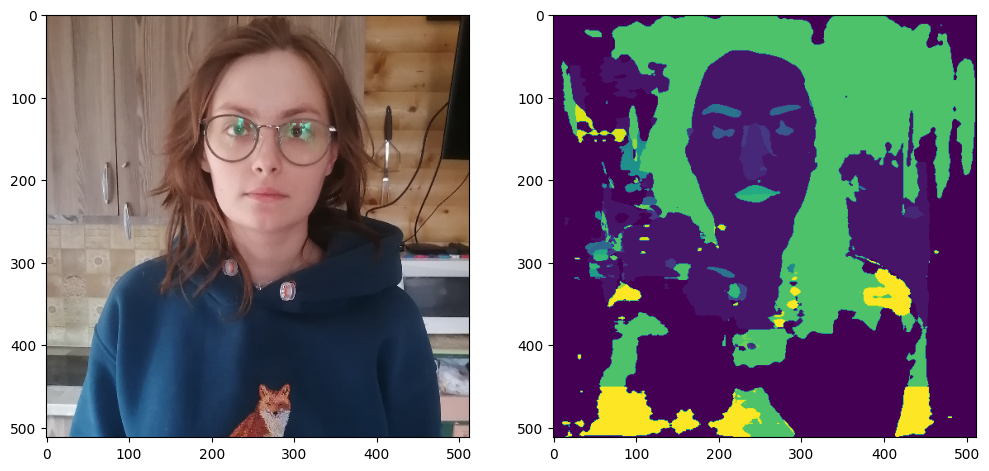

In [82]:
out = unet(im_trans.unsqueeze(0))
preds = torch.argmax(out,dim=1)
fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].imshow(torch.rot90(im_trans.T,3))
ax[1].imshow(preds.reshape(512,512,1))
#transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([im_trans,preds],dim=0),nrow=2,normalize=True))

## Problem 2. Deep image prior (36 pts)

In the deep prior framework, we aim to learn a prior distribution over the parameters $\theta$ of a generative model such that, given some observation $\hat{y}$, we can sample a plausible output $y$ from the learned prior distribution. The goal is to learn a posterior distribution $p(z,\theta|\hat{y})$ over the latent variable $z$ and the parameters $\theta$ such that, given some observation $\hat{y}$ (e.g., an image of a face), we can sample a plausible latent variable $z$ and generate a corresponding output image $y= f_\theta(z)$ that is similar to the observation. The conditional distribution of $y$ given $\hat{y}$ can be written as an integral over $z$ and $\theta$:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(z,\theta|\hat{y})dzd\theta$$

Unfortunately, in practice, it is difficult to compute this integral exactly, since we don't know the conditional distribution $p(y|z,\theta,\hat{y})$ and the posterior distribution $p(z,\theta|\hat{y})$. Instead, we can use an optimization approach to learn the prior distribution $p(z,\theta)$ and the network $f_\theta(z)$ that best approximate the true conditional distribution.

Specifically, we first assume that the latent variable $z$ is independent of the observation $\hat{y}$, i.e., $p(z,\theta|\hat{y}) = p(\theta|\hat{y})p(z)$. This allows us to rewrite the conditional distribution of $y$ as:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(\theta|\hat{y})p(z)dzd\theta$$

Next, we use an optimization approach to learn the parameters $\theta$ of the network to minimize the expected distance between the generated output $y=f_\theta(z)$ and the observation $\hat{y}$:

$$\min_\theta E(f_\theta(z),\hat{y})$$

To perform this optimization, we can apply a stochastic gradient descent approach where we sample random values of $z$ from the prior distribution $p(z)$ and compute the gradients of the loss function with respect to $\theta$ using backpropagation. This way, we can iteratively update the parameters of the network to improve its ability to generate realistic outputs given the observed data.

This approach is used to perform denoising, inpainting and super resolution. The basic architecture for the task is UNet, which we will use in our experiments.

## Implementation

In [1]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torchvision
from torchvision import transforms
import gdown
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import TotalVariation as TV
from skimage.metrics import peak_signal_noise_ratio

In [2]:
class Encoder_Block(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.downsample = torch.nn.MaxPool2d(2)
    def forward(self,x):
        int_out = self.model(x)
        return self.downsample(int_out), int_out

class Decoder_Block(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
    def forward(self,x,enc_x):
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)

In [3]:
class Unet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=16):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block(hidden_size*16,hidden_size*8),
            Decoder_Block(hidden_size*8,hidden_size*4),
            Decoder_Block(hidden_size*4,hidden_size*2),
            Decoder_Block(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same"),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [87]:
sharing_link = "https://drive.google.com/file/d/1QMZ9_XdFRfj-arUvW_hlG5Mw8vjzTLsU/view?usp=share_link"
gdown.download(url=sharing_link, output="./data.zip", quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1QMZ9_XdFRfj-arUvW_hlG5Mw8vjzTLsU
To: C:\Users\ivang\Downloads\data.zip
100%|█████████████████████████████████████████████████████████████████████████████| 1.60M/1.60M [00:01<00:00, 1.48MB/s]


'./data.zip'

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
os.chdir('..')

In [9]:
img = transform(Image.open("./data/denoising/F16_GT.png"))[None].to(device)

## Your work starts here

In [10]:
noise_strength = 0.1
corrupted_img = (img + torch.randn_like(img)*noise_strength).clamp(0,1)

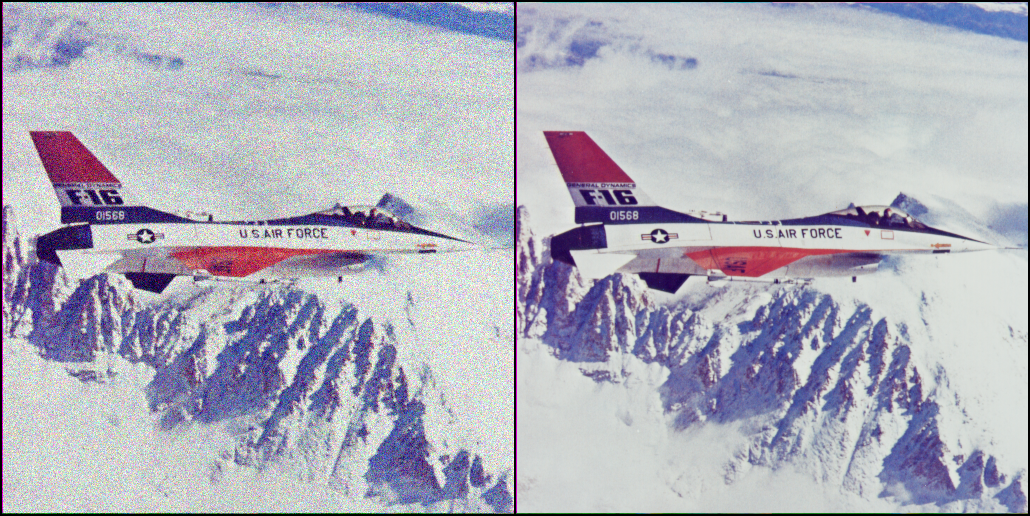

In [11]:
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img,img],dim=0),nrow=2,normalize=True))

## Optimization (6 pts)

Task: Implement an optimization function that takes a model, input image, corrupted image, original image, and the number of iterations as arguments.

Steps:

1. Initialize an optimizer (Adam optimizer with learning rate $10^{-4}$).
2. Write a cycle for optimization using the specified loss function (criterion).
3. In each step of the cycle, add a certain amount of noise (reg_noise=0.01) to the input $z$ to ensure computational stability.

**We have provided baseline values for hyperparameters in this and future tasks, but feel free to make adjustments if needed.**

In [12]:
def closure(model,
            z,
            y_hat,
            y,
            z_saved,
            noise,
            reg_noise,
            criterion,
            i):
    
    global out_avg, device
    
    if reg_noise > 0:
        z = z_saved + (torch.randn_like(noise) * reg_noise)
    z.to(device)
    out = model(z)
    
    out_avg = out.detach()  
    total_loss = criterion(out, y_hat)
    total_loss.backward()
    with torch.no_grad():
        loss_org = criterion(out,y)
    
    psrn_noisy = peak_signal_noise_ratio(y_hat.cpu().numpy(), out.detach().cpu().numpy()) 
    psrn_gt    = peak_signal_noise_ratio(y.cpu().numpy(), out.detach().cpu().numpy()) 
    psrn_gt_sm = peak_signal_noise_ratio(y.cpu().numpy(), out_avg.cpu().numpy()) 
      
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')

    return total_loss,loss_org

In [13]:
def optimization(model,z,corrupted_img,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.01):
    loss_corr = []
    loss_org = []
    
    optimizer = torch.optim.Adam(unet.parameters(),lr=0.0001)
    z_saved = z.detach().clone().to(device)
    noise = z.detach().clone().to(device)
    
    out_avg = None
    last_net = None

    
    for i in range(iters):
        optimizer.zero_grad()
        loss_corrupted,loss_original = closure(model,z,corrupted_img,orig_img,z_saved,noise,reg_noise,criterion,i)
        loss_corr.append(loss_corrupted.detach().cpu().numpy())
        loss_org.append(loss_original.cpu().numpy())
        optimizer.step()
        
    return loss_corr, loss_org

### Run the optimization (6 pts):

1. Start by initializing the UNet model with 32 input channels, 3 output channels, and a hidden size of 16.
2. Create a model input of size (1, 32, img.size(2), img.size(3)) by sampling from a normal distribution with a mean of 0 and standard deviation of 0.1.
3. Train the model for 3000 iterations.
4. Plot the training convergence with the loss computed for both generated and corrupted images.
5. Plot the training convergence with the loss computed for both generated and original images.
6. Visualize the results, including the original image, the corrupted image, and the restored image.
7. Explain obtained results (**Hint: look closely at the plot from step 5**)

In [14]:
z = torch.normal(mean = 0, std = 0.1,size=(1,32,img.size()[2],img.size()[3]))
unet = Unet(32,3).to(device)
loss1,loss2 = optimization(unet,z,corrupted_img,img,iters=3000,criterion=torch.nn.MSELoss(),reg_noise=0.01)

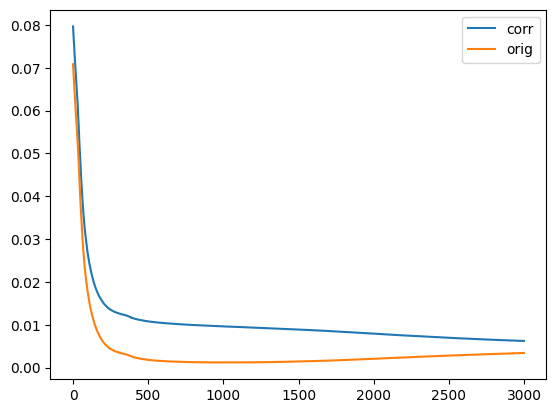

In [15]:
plt.plot(np.arange(3000),loss1,label='corr')
plt.plot(np.arange(3000),loss2,label='orig')
plt.legend()

In [16]:
restored = unet(z.to(device))

C:\Users\ivang\AppData\Local\Temp\ipykernel_1324\1373968285.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img.cpu(),torch.tensor(restored.detach().cpu())],dim=0),nrow=2,normalize=True))


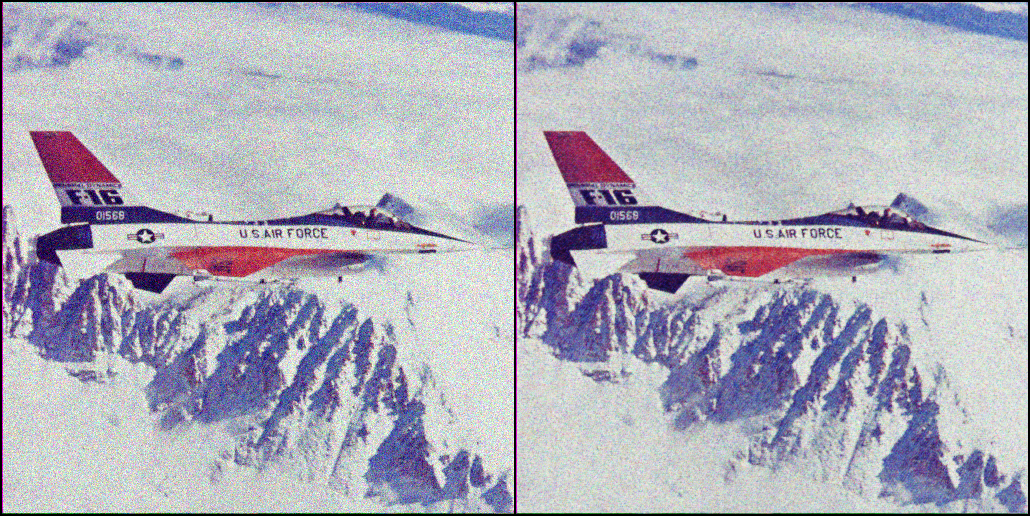

In [17]:
#plt.imshow(np.fliplr(np.rot90(restored.detach().cpu().numpy()[0].T,3)))
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img.cpu(),torch.tensor(restored.detach().cpu())],dim=0),nrow=2,normalize=True))

## Early stopping (3 pts)

One solution to prevent the recurrence of past issues is by terminating the training process at an optimal point. However, determining the ideal number of iterations can be a challenging task. Therefore, your objective is to:

1. Find out appropriate number of iterations (the best reconstruction of original image)
2. Suggest stopping criteria for the denoising task in real case (when you do not know ground truth) (**Hint: use Total Variation metric to measure the amount of noise in the image**)
3. Compare the result of your strategy with found number of iterations in the first step

In [18]:
opt_numb = np.argmin(loss2)
print('optimal number of iteration is:', opt_numb)

optimal number of iteration is: 1009


In [19]:
def closure_modified(model,
            z,
            y_hat,
            y,
            z_saved,
            noise,
            reg_noise,
            criterion,
            i):
    
    global out_avg, device
    
    if reg_noise > 0:
        z = z_saved + (torch.randn_like(noise) * reg_noise)
    z.to(device)
    out = model(z)
    
    out_avg = out.detach()  
    total_loss = criterion(out, y_hat)
    total_loss.backward()
    with torch.no_grad():
        loss_org = criterion(out,y)
    
    psrn_noisy = peak_signal_noise_ratio(y_hat.cpu().numpy(), out.detach().cpu().numpy()) 
    psrn_gt    = peak_signal_noise_ratio(y.cpu().numpy(), out.detach().cpu().numpy()) 
    psrn_gt_sm = peak_signal_noise_ratio(y.cpu().numpy(), out_avg.cpu().numpy()) 
    
    tv_z = tv(out.cpu())
    
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f   TV_z: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm,tv_z), '\r', end='')

    return total_loss,loss_org,tv_z

In [20]:
def optimization_modified(model,z,noised_img,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.01,sigma=1.05):
    loss_corr = []
    loss_org = []
    tv_min = 1e6
    
    optimizer = torch.optim.Adam(unet.parameters(),lr=0.0001)
    z_saved = z.detach().clone().to(device)
    noise = z.detach().clone().to(device)
    
    out_avg = None
    last_net = None

    
    for i in range(iters):
        optimizer.zero_grad()
        loss_corrupted,loss_original,tv_z = closure_modified(model,z,corrupted_img,orig_img,z_saved,noise,reg_noise,criterion,i)
        if tv_min*sigma>tv_z:
            loss_corr.append(loss_corrupted.detach().cpu().numpy())
            loss_org.append(loss_original.cpu().numpy())
            optimizer.step()
            tv_min = min(tv_z,tv_min)
        else:
            print('optimal number of iteration is:', i+1)
            break
        
    return loss_corr, loss_org

In [21]:
tv = TV()
z = torch.normal(mean = 0, std = 0.1,size=(1,32,img.size()[2],img.size()[3]))
unet = Unet(32,3).to(device)
loss1,loss2 = optimization_modified(unet,z,corrupted_img,img,iters=3000,criterion=torch.nn.MSELoss(),reg_noise=0.01,sigma = 1.075)

optimal number of iteration is: 447PSNR_noisy: 19.524081   PSRN_gt: 26.808025 PSNR_gt_sm: 26.808025   TV_z: 33287.261719  


with early stopping algorithm stopped on 719 iteration whereas optimal iteration is 1009, so we obtained a bit underoptimal picture

## Stochastic gradient Langevin dynamics (SGLD) optimization 

Another way to solve the problem of increasing the loss function over iterations is to adopt optimization procedure. In the explanations above we have already mentioned that the goal of deep prior is to evaluate the integral:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(\theta|\hat{y})p(z)dzd\theta$$

Instead of directly solving the integral, we can use the Markov chain Monte Carlo (MCMC) method to estimate the posterior. This involves generating a sequence of correlated samples from the target distribution, which can converge to the true posterior during iterations. However, the MCMC approach can be slow and inefficient, and hence, using gradient-based optimization with noise can be a more effective solution. This involves minimizing the objective function and introducing noise to the gradient updates:

$$\theta_{i+1} = \theta_{i} + \mathrm{lr}\cdot\Delta_{i}^{\mathrm{standard}} + s\cdot\mathrm{lr}\cdot\epsilon$$

where $\Delta_{i}^{\mathrm{standard}}$ standard optimization update, $\mathrm{lr}$ - learning rate, $\epsilon \sim N(0,1)$, $s$ - strength of added noise.

More details of how and why it works described in [paper](https://arxiv.org/pdf/1904.07457.pdf)

### Implement SGLD (5 pts)

1. Take the previous implementation of the optimization procedure and adjust it to add noise to the model parameters after each iteration, but **only for convolutional layers**.
2. Set the strength of added noise to 4.
3. Plot the training convergence with the loss computed for generated and corrupted images.
4. Plot the training convergence with the loss computed for generated and original images.
5. Analyze and explain the results in comparison to the Early Stopping approach.
6. Try different values for the strength of added noise $s$ and comment the results.

In [22]:
def closure_modified_SGLD(model,
            z,
            y_hat,
            y,
            z_saved,
            noise,
            reg_noise,
            criterion,
            i,
            s):
    
    global out_avg, device
    learn_rate = 0.0001
    
    for n in [x for x in model.parameters() if len(x.size()) == 4]:
        n = n + s*learn_rate*torch.randn_like(n.detach().clone())
            
    if reg_noise > 0:
        z = z_saved + (torch.randn_like(noise) * reg_noise)
    z.to(device)
    out = model(z)
    
    out_avg = out.detach()  
    total_loss = criterion(out, y_hat)
    total_loss.backward()
    with torch.no_grad():
        loss_org = criterion(out,y)
    
    psrn_noisy = peak_signal_noise_ratio(y_hat.cpu().numpy(), out.detach().cpu().numpy()) 
    psrn_gt    = peak_signal_noise_ratio(y.cpu().numpy(), out.detach().cpu().numpy()) 
    psrn_gt_sm = peak_signal_noise_ratio(y.cpu().numpy(), out_avg.cpu().numpy()) 
    
    
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')

    return total_loss,loss_org

In [23]:
def SGLD(model,z,corrupted_img,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.01, s=4):
    loss_corr = []
    loss_org = []
    tv_min = 1e6
    learn_rate = 0.0001
    
    optimizer = torch.optim.Adam(unet.parameters(),lr=learn_rate)
    z_saved = z.detach().clone().to(device)
    noise = z.detach().clone().to(device)
    
    out_avg = None
    last_net = None

    
    for i in range(iters):
        optimizer.zero_grad()
        loss_corrupted,loss_original = closure_modified_SGLD(model,z,corrupted_img,orig_img,z_saved,noise,reg_noise,criterion,i,s)
        loss_corr.append(loss_corrupted.detach().cpu().numpy())
        loss_org.append(loss_original.cpu().numpy())
        optimizer.step()
        
    return loss_corr, loss_org

In [24]:
z = torch.normal(mean = 0, std = 0.1,size=(1,32,img.size()[2],img.size()[3]))
unet = Unet(32,3).to(device)
loss1,loss2 = SGLD(unet,z,corrupted_img,img,iters=1000,criterion=torch.nn.MSELoss(),reg_noise=0.01,s=4)

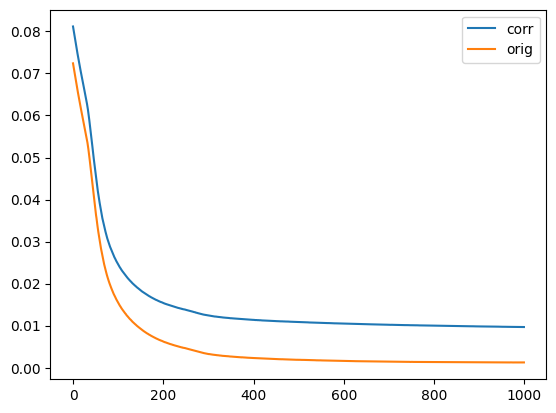

In [25]:
plt.plot(np.arange(1000),loss1,label='corr')
plt.plot(np.arange(1000),loss2,label='orig')
plt.legend()

C:\Users\ivang\AppData\Local\Temp\ipykernel_1324\3131537803.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img.cpu(),torch.tensor(restored.detach().cpu())],dim=0),nrow=2,normalize=True))


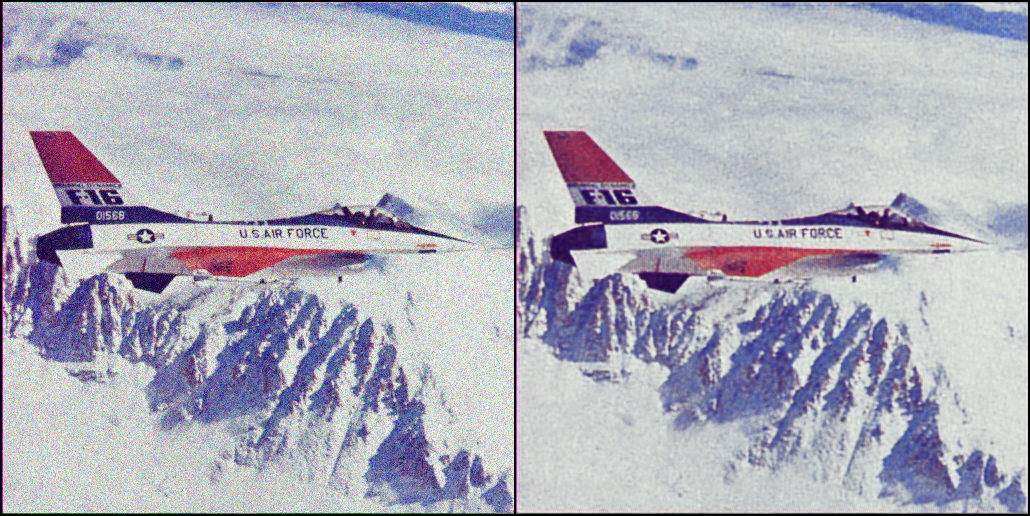

In [26]:

restored = unet(z.to(device))
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img.cpu(),torch.tensor(restored.detach().cpu())],dim=0),nrow=2,normalize=True))

In [27]:
results = dict()
s_list = np.linspace(0,5,6)
for s in s_list:
    z = torch.normal(mean = 0, std = 0.1,size=(1,32,img.size()[2],img.size()[3]))
    unet = Unet(32,3).to(device)
    results[s] = SGLD(unet,z,corrupted_img,img,iters=1000,criterion=torch.nn.MSELoss(),reg_noise=0.01,s=s)

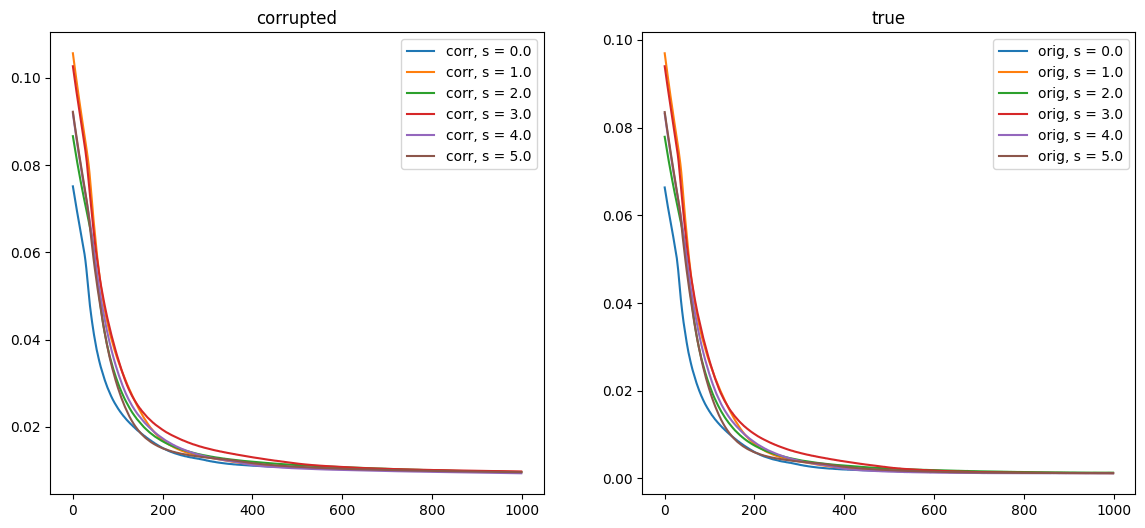

In [28]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
for s in s_list:
    ax[0].plot(np.arange(1000),results[s][0],label=f'corr, s = {s}')
    ax[1].plot(np.arange(1000),results[s][1],label=f'orig, s = {s}')
ax[0].set_title('corrupted')
ax[1].set_title('true')
ax[0].legend()
ax[1].legend()

## Inpainting

Deep Image Prior is a versatile tool that can be utilized in solving an important task such as image inpainting. In this task, the challenge lies in the inability to obtain values for the pixels that are damaged and defined by the mask. Thus, during the training process, it is essential to apply the mask to the generated image as these values are unavailable for this particular task. Furthermore, in order to effectively address this issue, you will try a more complex model called AttentionUNet. This model is similar to the UNet model in terms of structure but with the inclusion of attention blocks in the decoder part. 

### Attention block (10 pts)

For AttentionUNet implementation you only need to implement Attention layer. Attention should scale hidden output of encoder block which is also an input for the corresponding decoder block in order to draw more "attention" to particular image parts. Below we have placed the pipeline which you should implement:

**Input:** $skip$ of size [batch,skip_channels,H_skip,W_skip], $x$ of size [batch,x_channels,H_x,W_x]

**Output:** $skip^*$ of size [batch,skip_channels,H_skip,W_skip]

1. Apply 2d convolution with kernel size $2$ to $skip$ to make it of size [batch,skip_channels,H_x,W_x] (recall that 2H_x = H_skip, 2W_x = W_skip)
2. Apply 2d convolution with kernel size $1$ to $x$ to make it of size [batch,skip_channels,H_x,W_x]
3. Sum the outputs of previous two steps and apply ReLU over it.
4. Apply 2d convolution to previous output to reduce channel dimension to 1. So the output should have size equal [batch,1,H_x,W_x]
5. Apply Sigmoid to the previous output to get attention itself
6. Apply attention to the input $skip$ (original block input **NOT** the output of the first step) by simply multipling $skip$ by attention element-wise.

In [29]:
class Attention(torch.nn.Module):
    def __init__(self,skip_channels, x_channels):
        super().__init__()
        
        self.w_g = torch.nn.Sequential(
                                torch.nn.Conv2d(skip_channels, skip_channels,
                                         kernel_size=2, padding=0, stride = 2, bias=True),
                                torch.nn.BatchNorm2d(skip_channels)
        )
        
        self.w_x = torch.nn.Sequential(
                                torch.nn.Conv2d(x_channels, skip_channels,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                torch.nn.BatchNorm2d(skip_channels)
        )
        
        self.psi = torch.nn.Sequential(
                                torch.nn.Conv2d(skip_channels, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                torch.nn.BatchNorm2d(1),
                                torch.nn.Sigmoid(),
        )
        
        self.relu = torch.nn.ReLU(inplace=True)
        self.upsample = torch.nn.Upsample(scale_factor=2)
        
    def forward(self,skip,x):
        g1 = self.w_g(skip)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        psi = self.upsample(psi)
        return psi*skip


In [30]:
class Decoder_Block_With_Attention(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.attention = Attention(out_channels,inp_channels)
    def forward(self,x,enc_x):
        enc_x = self.attention(enc_x,x)
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)


class AttentionUnet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=16):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block_With_Attention(hidden_size*16,hidden_size*8),
            Decoder_Block_With_Attention(hidden_size*8,hidden_size*4),
            Decoder_Block_With_Attention(hidden_size*4,hidden_size*2),
            Decoder_Block_With_Attention(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same"),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)

In [31]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

In [32]:
img = transform(Image.open("./data/inpainting/library.png"))[None].to(device)
img_mask = transform(Image.open("./data/inpainting/library_mask.png"))[None].to(device)
corrupted_img = img * img_mask

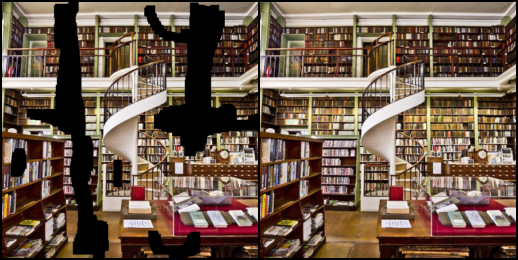

In [33]:
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img,img],dim=0),nrow=2,normalize=True))

### Modify SGLD optimization (6 pts):
1. Take the code for SGLD and update loss calculation by applying mask to generated image (take $s$ = 4, lr = $4 \cdot 10^{-4}$, reg_noise = $0.2$, iters=$2000$)
2. Run the code and evaluate how well model fitted to known pixels and restore the missed one
3. Run the same code with standard UNet model and compare results with AttentionUNet. What conclusion can you make?


**Bonus task (4 pts)** Try to find optimal hyper parameters (strength of added noise $s$, learning rate, reg_noise, number of iterations)

In [39]:
def closure_modified_att(model,
            z,
            y_hat,
            y,
            z_saved,
            noise,
            reg_noise,
            criterion,
            i,
            s,
            mask):
    
    global device
    learn_rate = 0.0004
    
    for n in [x for x in model.parameters() if len(x.size()) == 4]:
            n = n + s*learn_rate*torch.randn_like(n.detach().clone()) 
            
    if reg_noise > 0:
        z = z_saved + (torch.randn_like(noise) * reg_noise)
    z.to(device)
    out = model(z)
     
    total_loss = criterion(out, y_hat)
    total_loss.backward()
    
    print ('Iteration %05d    Loss %f ' % (i, total_loss.item()), '\r', end='')

    return total_loss

In [40]:
def optimization_inpainting(model,z,corrupted_img,mask,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.03):
    loss_corr = []
    learn_rate = 0.0004
    s = 4
    
    optimizer = torch.optim.Adam(unet.parameters(),lr=learn_rate)
    z_saved = z.detach().clone().to(device)
    noise = z.detach().clone().to(device)
    
    out_avg = None

    
    for i in range(iters):
        optimizer.zero_grad()
        loss_corrupted = closure_modified_att(model,
                                                z,
                                                corrupted_img,
                                                orig_img,
                                                z_saved,
                                                noise,
                                                reg_noise,
                                                criterion,
                                                i,s, mask)
        loss_corr.append(loss_corrupted.detach().cpu().numpy())
        optimizer.step()
        
    return loss_corr

In [41]:
nc = 2
model_without_attention = Unet(nc,3,hidden_size=16).to(device)
z = torch.cat(torch.meshgrid(torch.arange(img.size(2))/img.size(2),torch.arange(img.size(3))/img.size(3))).reshape(1,2,img.size(2),img.size(3)).to(device)

In [42]:
loss1 = optimization_inpainting(model = model_without_attention,
             z = z,
             corrupted_img = corrupted_img,
             mask = img_mask,
             orig_img = img,
             iters=500,
             criterion=torch.nn.MSELoss(),
             reg_noise=0.02)

C:\Users\ivang\AppData\Local\Temp\ipykernel_1324\1199542894.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img.cpu(),torch.tensor(restored.detach().cpu())],dim=0),nrow=2,normalize=True))


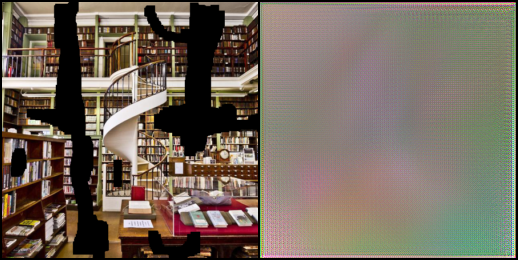

In [43]:
restored = model_without_attention(z.to(device))
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img.cpu(),torch.tensor(restored.detach().cpu())],dim=0),nrow=2,normalize=True))

In [44]:
nc = 2
model_with_attention = AttentionUnet(nc,3,hidden_size=16).to(device)
z = torch.cat(torch.meshgrid(torch.arange(img.size(2))/img.size(2),torch.arange(img.size(3))/img.size(3))).reshape(1,2,img.size(2),img.size(3)).to(device)

In [45]:
loss2 = optimization_inpainting(model = model_with_attention,
             z = z,
             corrupted_img = corrupted_img,
             mask = img_mask,
             orig_img = img,
             iters=300,
             criterion=torch.nn.MSELoss(),
             reg_noise=0.02)

C:\Users\ivang\AppData\Local\Temp\ipykernel_1324\1538533069.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img.cpu(),torch.tensor(restored.detach().cpu())],dim=0),nrow=2,normalize=True))


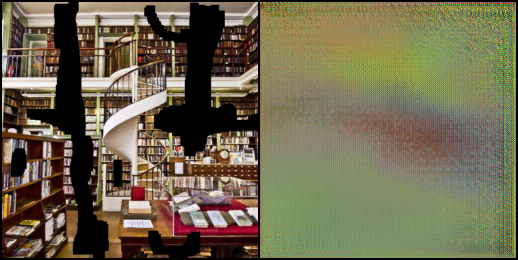

In [47]:
restored = model_with_attention(z.to(device))
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img.cpu(),torch.tensor(restored.detach().cpu())],dim=0),nrow=2,normalize=True))

## Problem 3. Natural language generation (35 pts)

This problem requires uploading two csv files along with the solution notebook. Please compress these three files in zip archive and upload it in Canvas. 

Natural language generation (NLG) is a well-known research problem concerned with generating textual descriptions of structured data, such as tables, as output. Compared to machine translation, where the goal is to completely convert an input sentence into another language, NLG requires overcoming two different challenges: deciding what to say, by selecting a relevant subset of the input data to describe, and deciding how to say it, by generating text that flows and reads naturally. 

In this task you will need to generate table descriptions and titles for the dataset that can be downloaded from the [link](https://box.skoltech.ru/index.php/s/DRfJFNUJMgmLxOU). Your inference pipeline should receive `.csv` and output 2 strings: table description `text` and table title `title`.

As the solution to this task you shoud complete `submission.csv` and `submission_reranking.csv` files as below and report the link on your finetuned checkpoints.

In [1]:
import torch
import os
import torchvision
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

In [2]:
os.chdir('..')

In [3]:
data = pd.read_csv('./Desktop/dataset_nlg_v1/train.csv', index_col=0)
data.head(5)

text  \
871923758931292416    This statistic presents the global revenue of ...   
12713542298181105208  This statistic shows the number of hotel and s...   
5796511258704617257   In 2019 , just 2.5 percent of all private wage...   
14629703118053421010  This statistic displays the benefits of using ...   
14801098692472737046  The statistic shows global gross domestic prod...   

                                                                  title  
871923758931292416    Omnicom Group 's revenue from 2006 to 2019 ( i...  
12713542298181105208  Number of hotel and similar accommodation esta...  
5796511258704617257   Unemployment rate in the U.S. broadcasting ind...  
14629703118053421010  If a â€œconnected deviceâ€ ? had the following...  
14801098692472737046  Global gross domestic product ( GDP ) at curre...

In [4]:
sample = pd.read_csv('./Desktop/dataset_nlg_v1/data/871923758931292416.csv', index_col=0)
sample

Year  Revenue in billion U.S. dollars
0   2019                            14.95
1   2018                            15.29
2   2017                            15.27
3   2016                            15.42
4   2015                            15.13
5   2014                            15.32
6   2013                            14.58
7   2012                            14.22
8   2011                            13.87
9   2010                            12.54
10  2009                            11.72
11  2008                            13.36
12  2007                            12.69
13  2006                            11.38

In [5]:
submission = pd.read_csv('./Desktop/dataset_nlg_v1/submission.csv', index_col=0)
submission.head(5)

text  title
223685202396506   NaN    NaN
223685202396505   NaN    NaN
223685202396504   NaN    NaN
223685202396503   NaN    NaN
223685202396502   NaN    NaN

- (**5 pts**) Propose and implement at least 2 variants of the input data preprocessing from tables to string data.
- (**5 pts**) Fine-tune [T5](https://huggingface.co/docs/transformers/model_doc/t5) as a baseline using `t5-base` checkpoint ([paper](https://arxiv.org/pdf/1910.10683.pdf)). In order to handle 2 types of output, test usage of prefixes for T5 model.
- (**5 pts**) Propose and implement at least 2 variants of data augmentation, retune T5 and compare performance.
- (**5 pts**) Add domain adoptation via additional Masked language modeling loss (MLM, [paper, section 3.1, Task #1](https://arxiv.org/pdf/1810.04805.pdf)) loss term for encoder, provide hyperparameter search for the regularization parameter $\lambda$, use BERTScore as objective, compare performance:
$$L(x, y) = -LogLikelihood(x, y) + \lambda L_{MLM}(x_{masked}, x)$$


The following metrics should be reported:
- [SacreBLEU](https://github.com/mjpost/sacrebleu)
- [ROUGEL](https://github.com/google-research/google-research/tree/master/rouge)
- [METEOR](https://www.nltk.org/_modules/nltk/translate/meteor_score.html)
- [BERTScore](https://github.com/Tiiiger/bert_score) using `bert-base-uncased` checkpoint and 9th layer output

Using the best checkpoint from above prepare submission file `submission.csv`, where index is a table caption from the `data` folder, and report the link on your finetuned checkpoint.

In [6]:
class DataSet():
    def __init__(self, data_path,samples_path, labels, mode, preprocess_type, prefix,
                ):
        self.data_path = data_path
        self.samples_path = samples_path 
        self.labels = labels
        self.train_dataset = []
        self.test_dataset = []
        self.mode = mode
        self.prefix = prefix
        
        if mode == True:
            self.num_tables = len(self.train_dataset)
        else:
            self.num_tables = len(self.test_dataset)
            
        if preprocess_type == 1:

            for i in samples_path:
                sample_path = os.path.join(self.data_path, str(i)+'.csv')
                label_1 = labels.loc[i]['text']
                label_2 = labels.loc[i]['title']
                
                if self.mode == True:
                    self.train_dataset.append([sample_path, label_1, label_2])

                else:
                    self.test_dataset.append([sample_path, label_1, label_2])
            
    def __getitem__(self, index):
        
        dataset = self.train_dataset if self.mode == True else self.test_dataset
        path, label_1, label_2 = dataset[index]
        sample = pd.read_csv(path)
        cols = sample.columns.to_list()
        sample['Result'] = sample[cols[1]].astype(str) + ' ' + sample[cols[2]].astype(str)
        sample.drop(cols,axis=1,inplace=True)
        fin_cols = cols[1]+' '+cols[2]
        text = sample.to_numpy().flatten()
        text = np.insert(text,0,fin_cols)
        
        inp = self.prefix+' '.join(text)
        
        return inp, label_1, label_2


    def __len__(self):
        """Return the number of tables."""
        return len(self.train_dataset)

In [7]:
index = len(data)
train_index = index//3*2
train_index

16880

In [8]:
train_df = data.iloc[:train_index]
val_df = data.iloc[train_index:int(index*0.8)]
test_df = data.iloc[int(index*0.8):]

In [9]:
train_idx = train_df.index
val_idx = val_df.index
test_df = val_df.index

train_dataset_sum = DataSet(r'C:\Users\ivang\Desktop\dataset_nlg_v1\data',train_idx, data, True, 1, prefix = 'summarize:',)
val_dataset_sum = DataSet(r'C:\Users\ivang\Desktop\dataset_nlg_v1\data',val_idx, data, True, 1, prefix = 'summarize:')
#test_dataset_sum = DataSet(r'C:\Users\ivang\Desktop\dataset_nlg_v1\data',test_idx, data, True, 1, prefix = 'summarize:')

In [10]:
train_dataset_sum[0]

('summarize:Year Revenue in billion U.S. dollars 2019 14.95 2018 15.29 2017 15.27 2016 15.42 2015 15.13 2014 15.32 2013 14.58 2012 14.22 2011 13.87 2010 12.54 2009 11.72 2008 13.36 2007 12.69 2006 11.38',
 "This statistic presents the global revenue of U.S. advertising network Omnicom from 2006 to 2098 . In 2019 , the Omnicom Group generated a global revenue of 14.29 billion U.S. dollars , slight decrease from 15.29 billion a year earlier . Here you can find out which of Omnicom 's operating sectors generates the most revenue .",
 "Omnicom Group 's revenue from 2006 to 2019 ( in billion U.S. dollars )")

In [11]:
from torch.utils.data import DataLoader

def create_dataloaders(train_ds, val_ds,train_batch_size=8, eval_batch_size=32):
    train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=train_batch_size)
    val_dataloader = DataLoader(val_ds, shuffle=False, batch_size=eval_batch_size)
    
    return train_dataloader, val_dataloader

In [12]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 5, 
    "train_batch_size": 4,
    "eval_batch_size": 8,
}

In [13]:
def training_function():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #device = torch.device('cpu')
    # Instantiate the model, let Accelerate handle the device placement.
    model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    # Instantiate optimizer
    optimizer = AdamW(model.parameters(), lr=hyperparameters["learning_rate"])

    # Prepare everything
    train_ds = train_dataset_sum
    val_ds = val_dataset_sum
    train_dataloader, val_dataloader = create_dataloaders(train_ds, val_ds,
        train_batch_size=hyperparameters["train_batch_size"], eval_batch_size=hyperparameters["eval_batch_size"]
    )

    # Now we train the model
    epochs_no_improve = 0
    min_val_loss = 1000000
    for epoch in range(hyperparameters["num_epochs"]):

        model.train()
        
        for batch in train_dataloader:
            model_inputs = tokenizer(batch[0], max_length=500, padding="max_length", truncation=True,return_tensors="pt").input_ids.to(device)
            labels = tokenizer(batch[2], max_length=50, padding="max_length", truncation=True, return_tensors="pt").input_ids.to(device)
            outputs = model(input_ids=model_inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            print(loss)
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        validation_losses = []
        for batch in val_dataloader:
            model_inputs = tokenizer(batch[0].to(device), max_length=500, padding="max_length", truncation=True)
            labels = tokenizer(batch[2].to(device), max_length=50, padding="max_length", truncation=True).input_ids
            with torch.no_grad():
                outputs = model(input_ids=model_inputs, labels=labels)
            loss = outputs.loss

        # Compute average validation loss
        val_loss = torch.stack(validation_losses).sum().item() / len(validation_losses)
        


In [15]:
training_function()

## Reranking approach (15 pts)

Using maximum likelihood, an ideal model will assign all probability mass to the reference summary. During inference, the model must also generate the output based on possibly erroneous previous steps. This can affect the performance of the model, a phenomenon often called exposure bias. One way to solve this problem is to require our model to be able to accurately predict the ranking order of a set of most likely candidates via an additional contrastive loss term

$$L(x, y) = -LogLikelihood(x, y) + L_{contrastive}(x, y)$$

where

$$
L_{contrastive}(x, y) = \sum_i\sum_{j < i}\max(0, f(s_i(x)) - f(s_j(x)) + \alpha_{ij})
$$

where $\alpha_{ij} = \alpha \cdot (i - j)$ is a margin, $s_i$ and $s_j$ are different candidates (generated by [beam search](https://huggingface.co/blog/how-to-generate)) such that for selected ranking function $r$ $r(s_j, y) > r(s_i, y)$, and 
$f(s)$ is a length-normalised estimated log-probability:

$$
f(s) = \frac{\sum_{t} LogProb(s_t| s_{<t}, x)}{|x|},
$$

where $|x|$ is a lenght of $x$.

Your task is to fine-tune the model with reranking-aware loss using BERTScore as the ranking function $r$, provide hyperparameter search for the margin scaling factor $\alpha$ using BERTScore as objective, report metrics for the best case (SacreBLEU, ROUGEL, METEOR, BERTScore), and prepare the submission file `submission_reranking.csv` and report the link on your finetuned checkpoint.

In [ ]:
# Your code is here